In [1]:
import pandas as pd
import seaborn as snb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read the Stamping data from the Excel file
df = pd.read_excel('Raw_Data_v0.xlsx')

In [3]:
df = df.drop(columns=['Ref#','Heat treatment','Other RM/Rivet/part cost (€/Part)','Gross Weight (g)','Other assembled RM/Rivet/part','Heat Treatment cost (€/Part)'])
df['Raw Material'] = df['Raw Material'].str.title()
df = df.fillna('0')


In [4]:
df

,Production,Annual target quantity,Raw Material,Raw Material Designation,Surface Treatment,Raw Material Cost (€/kg),Thickness (mm),Part Net Weight (g),Final Raw Material cost (€/Part),Surface Treatment cost (€/Part),Total cost with amortization (€/part)
0,A,1500000.0,Copper,Cu-ETP-R240,0,9.400663,1.5,3.000,0.035346,0.000000,0.051500
1,A,1000000.0,Copper,Cu-ETP-R240,Sn5,9.804307,1.6,3.200,0.038595,0.004970,0.058863
2,A,1500000.0,Copper,Cu-ETP-R240,Sn5,9.804307,1.3,5.107,0.064738,0.006737,0.089343
3,A,1500000.0,Copper,Cu-ETP-R240,Sn5,9.401325,1.5,3.731,0.042341,0.006184,0.057637
4,A,1500000.0,Steel,DC03,Sn5,1.236886,1.5,3.300,0.006726,0.006184,0.018332
...,...,...,...,...,...,...,...,...,...,...,...
154,E,44538.0,Copper,Cu-ETP-R240,0,9.354414,6.0,0.056,0.799868,0.000000,1.538638
155,E,38260.0,Steel,SUS304 1/2H,0,3.689065,2.5,0.034,0.220553,0.000000,0.353694
156,E,13478.0,Steel,SPCC-2B,ZnCr3+,1.185771,2.0,0.064,0.191041,0.092227,0.648388
157,E,38260.0,Steel,SPCC-2B,ZnCr3+,1.185771,2.0,0.010,0.025296,0.013175,0.097968


C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(



=== Cross-Validation Results ===
Mean RMSE: 0.3714
Std RMSE: 0.4801

=== Training Models ===


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Training quantile models...

=== Enhanced Performance Metrics ===
Metric    Value
  RMSE 0.114299
   MAE 0.051142
    R² 0.972114

=== Overfitting Analysis ===
Training R²: 0.9721
Training-Test Gap: 0.0000

Key Features (>5% importance): ['Annual target quantity', 'Final Raw Material cost (€/Part)', 'Surface Treatment cost (€/Part)']


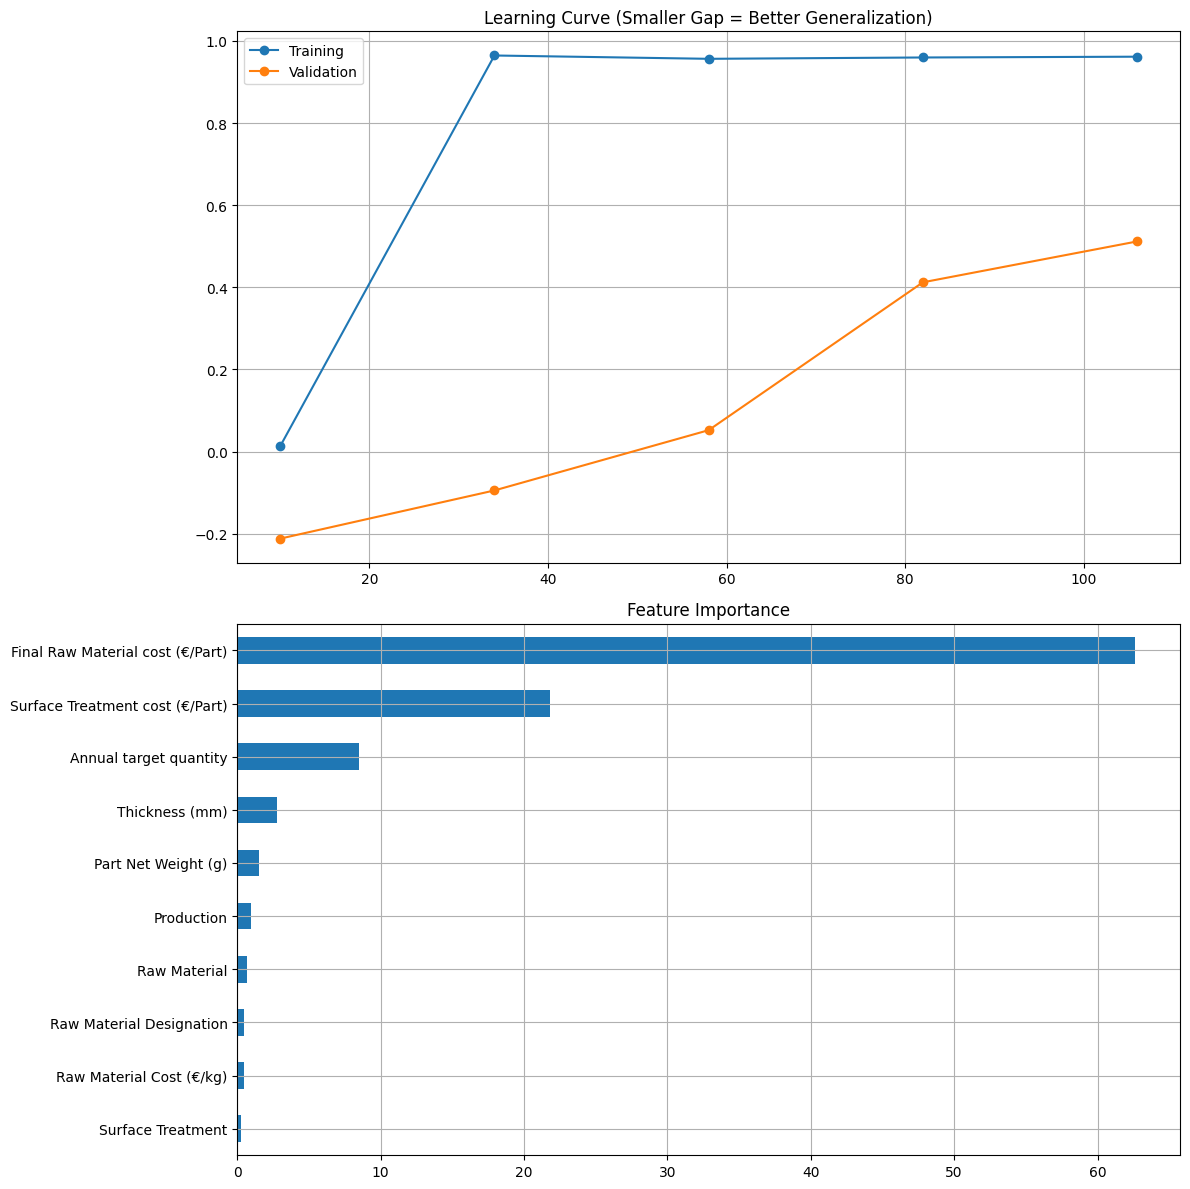

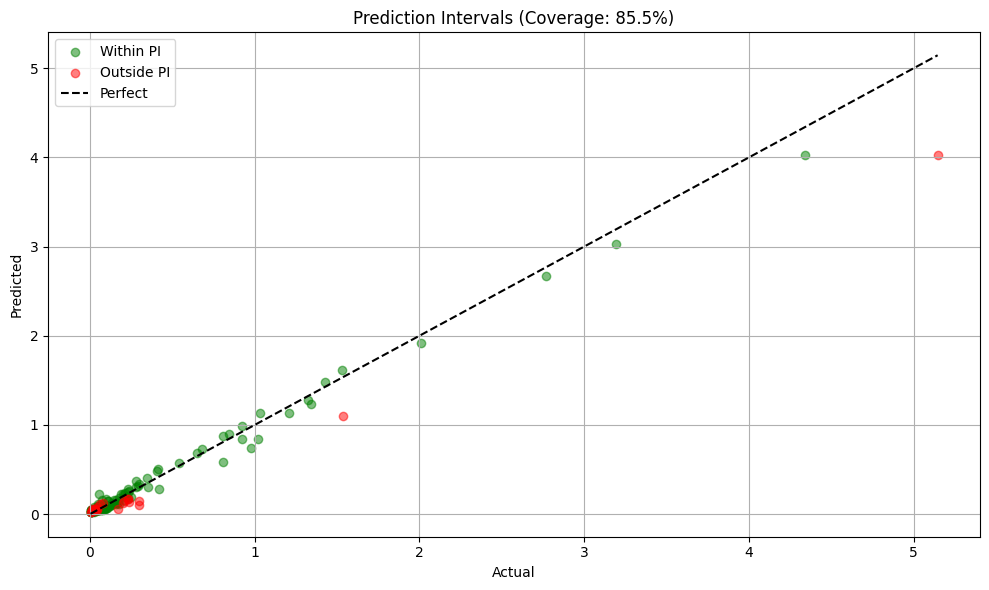


=== Prediction Interval Analysis ===
Coverage: 85.53% (Target: 80%)
Average Width: 0.3659
Width Std Dev: 0.7154


In [5]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# --- Feature Lists ---
features_to_scale = [
    'Annual target quantity', 
    'Raw Material Cost (€/kg)', 
    'Thickness (mm)',
    'Part Net Weight (g)', 
    'Final Raw Material cost (€/Part)', 
    'Surface Treatment cost (€/Part)'
]

categorical_features = [
    'Production',
    'Raw Material',
    'Raw Material Designation',
    'Surface Treatment'
]

# --- Clean Categorical Columns ---
for col in categorical_features:
    df[col] = df[col].astype(str)

# --- Data Preparation ---
scaler = RobustScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

selected_features = features_to_scale + categorical_features
X = df[selected_features]
y = df['Total cost with amortization (€/part)']

# --- Model Training with Regularization ---
final_model = CatBoostRegressor(
    depth=3,
    iterations=600,
    learning_rate=0.03,
    l2_leaf_reg=20,
    subsample=0.5,
    min_data_in_leaf=10,
    grow_policy='Depthwise',
    early_stopping_rounds=20,
    od_type='IncToDec',
    verbose=0
)

# --- Cross-Validation ---
try:
    cv_results = cross_val_score(
        final_model, X, y, cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        fit_params={'cat_features': categorical_features}
    )
    print(f"\n=== Cross-Validation Results ===")
    print(f"Mean RMSE: {np.sqrt(-cv_results.mean()):.4f}")
    print(f"Std RMSE: {np.sqrt(cv_results.std()):.4f}")
except Exception as e:
    print(f"CV Error: {str(e)}")

# --- Quantile Models ---
quantile_params = {
    'depth': 2,
    'iterations': 300,
    'learning_rate': 0.02,
    'l2_leaf_reg': 30,
    'subsample': 0.4,
    'min_data_in_leaf': 15,
    'grow_policy': 'Depthwise'
}

lower_model = CatBoostRegressor(
    **quantile_params,
    loss_function='Quantile:alpha=0.1',
    verbose=0
)

upper_model = CatBoostRegressor(
    **quantile_params,
    loss_function='Quantile:alpha=0.9',
    verbose=0
)

# --- Model Fitting ---
print("\n=== Training Models ===")
final_model.fit(X, y, cat_features=categorical_features, plot=True)
print("\nTraining quantile models...")
lower_model.fit(X, y, cat_features=categorical_features)
upper_model.fit(X, y, cat_features=categorical_features)

# --- Predictions ---
y_pred = final_model.predict(X)
y_lower = lower_model.predict(X)
y_upper = upper_model.predict(X)

# --- Evaluation ---
print("\n=== Enhanced Performance Metrics ===")
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

metrics = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R²'],
    'Value': [rmse, mae, r2]
})
print(metrics.to_string(index=False))

# --- Overfitting Analysis ---
print("\n=== Overfitting Analysis ===")
train_r2 = r2_score(y, y_pred)
print(f"Training R²: {train_r2:.4f}")
print(f"Training-Test Gap: {train_r2 - r2:.4f}")

# --- Feature Importance ---
feature_imp = final_model.get_feature_importance()
imp_threshold = 0.05 * sum(feature_imp)
important_features = [f for f, imp in zip(selected_features, feature_imp) if imp > imp_threshold]
print(f"\nKey Features (>5% importance): {important_features}")

# --- Visualizations ---
plt.figure(figsize=(12, 12))

# 1. Learning Curve
plt.subplot(2, 1, 1)
train_sizes, train_scores, val_scores = learning_curve(
    final_model, X, y, cv=3, scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1,
    fit_params={'cat_features': categorical_features}
)
plt.plot(train_sizes, np.mean(train_scores, 1), 'o-', label='Training')
plt.plot(train_sizes, np.mean(val_scores, 1), 'o-', label='Validation')
plt.title("Learning Curve (Smaller Gap = Better Generalization)")
plt.legend()
plt.grid()

# 2. Feature Importance
plt.subplot(2, 1, 2)
pd.Series(feature_imp, index=selected_features).sort_values().plot.barh()
plt.title("Feature Importance")
plt.grid()

plt.tight_layout()
plt.show()

# --- Prediction Interval Visualization ---
plt.figure(figsize=(10, 6))
within_bounds = (y >= y_lower) & (y <= y_upper)
plt.scatter(y[within_bounds], y_pred[within_bounds], c='green', alpha=0.5, label='Within PI')
plt.scatter(y[~within_bounds], y_pred[~within_bounds], c='red', alpha=0.5, label='Outside PI')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label='Perfect')
plt.title(f"Prediction Intervals (Coverage: {np.mean(within_bounds):.1%})")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# --- Prediction Interval Stats ---
print("\n=== Prediction Interval Analysis ===")
print(f"Coverage: {np.mean(within_bounds):.2%} (Target: 80%)")
print(f"Average Width: {np.mean(y_upper - y_lower):.4f}")
print(f"Width Std Dev: {np.std(y_upper - y_lower):.4f}")


0:	learn: 0.7331597	test: 0.3443569	best: 0.3443569 (0)	total: 12.3ms	remaining: 7.38s
100:	learn: 0.4583591	test: 0.1328876	best: 0.1328876 (100)	total: 1.46s	remaining: 7.22s
200:	learn: 0.3154900	test: 0.0825442	best: 0.0825442 (200)	total: 3.28s	remaining: 6.5s
300:	learn: 0.2382174	test: 0.0655719	best: 0.0655719 (300)	total: 5.31s	remaining: 5.28s
400:	learn: 0.1889064	test: 0.0580017	best: 0.0580017 (400)	total: 7.48s	remaining: 3.71s
500:	learn: 0.1533879	test: 0.0534593	best: 0.0534593 (500)	total: 9.64s	remaining: 1.91s
599:	learn: 0.1275744	test: 0.0516998	best: 0.0515200 (594)	total: 12s	remaining: 0us

bestTest = 0.05151997807
bestIteration = 594

Shrink model to first 595 iterations.


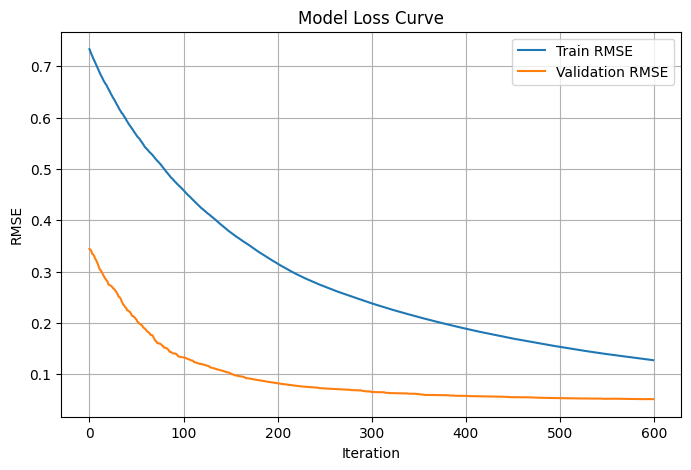

=== Test Set Metrics ===
RMSE: 0.0515
MAE:  0.0432
R²:   0.9750


In [6]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# --- Feature Lists ---
features_to_scale = [
    'Annual target quantity', 
    'Raw Material Cost (€/kg)', 
    'Thickness (mm)',
    'Part Net Weight (g)', 
    'Final Raw Material cost (€/Part)', 
    'Surface Treatment cost (€/Part)'
]

categorical_features = [
    'Production',
    'Raw Material',
    'Raw Material Designation',
    'Surface Treatment'
]

# --- Clean Categorical Columns ---
for col in categorical_features:
    df[col] = df[col].astype(str)

# --- Scaling ---
scaler = RobustScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# --- Train/Test Split ---
selected_features = features_to_scale + categorical_features
X = df[selected_features]
y = df['Total cost with amortization (€/part)']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Sample Weights for Imbalance (regression bins) ---
y_bins = pd.qcut(y_train, q=10, duplicates='drop')
bin_counts = y_bins.value_counts()
# Inverse frequency weighting per bin
y_train_weights = y_bins.map(lambda b: 1.0 / bin_counts[b])
# Normalize weights
y_train_weights *= len(y_train) / y_train_weights.sum()

# --- CatBoost Model ---
model = CatBoostRegressor(
    depth=3,
    iterations=600,
    learning_rate=0.03,
    l2_leaf_reg=20,
    subsample=0.5,
    min_data_in_leaf=10,
    grow_policy='Depthwise',
    early_stopping_rounds=20,
    od_type='IncToDec',
    verbose=100
)

# --- Fit with eval_set to track loss ---
model.fit(
    X_train, y_train,
    cat_features=categorical_features,
    sample_weight=y_train_weights,
    eval_set=(X_test, y_test),
    use_best_model=True
)

# --- Learning Curve: Loss vs Iterations ---
evals = model.get_evals_result()
train_rmse = evals['learn']['RMSE']
val_rmse = evals['validation']['RMSE']
iterations = list(range(len(train_rmse)))

plt.figure(figsize=(8, 5))
plt.plot(iterations, train_rmse, label='Train RMSE')
plt.plot(iterations, val_rmse, label='Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Model Loss Curve')
plt.legend()
plt.grid()
plt.show()

# --- Final Evaluation on Test Set ---
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("=== Test Set Metrics ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# --- (Optional) Quantile Regression ---
# If you need prediction intervals, uncomment the following:
#
# lower_model = CatBoostRegressor(**quantile_params, loss_function='Quantile:alpha=0.1', verbose=0)
# upper_model = CatBoostRegressor(**quantile_params, loss_function='Quantile:alpha=0.9', verbose=0)
# lower_model.fit(X_train, y_train, cat_features=categorical_features, sample_weight=y_train_weights)
# upper_model.fit(X_train, y_train, cat_features=categorical_features, sample_weight=y_train_weights)

# --- Feature importance removed as requested ---



[I 2025-04-29 10:27:13,205] A new study created in memory with name: no-name-f62526d9-ca0a-4606-a079-45c1ed3fc27f
C:\Users\adria\AppData\Local\Temp\ipykernel_23676\229047084.py:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\adria\AppData\Local\Temp\ipykernel_23676\229047084.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 100),
[I 2025-04-29 10:27:22,990] Trial 0 finished with value: 0.05985203009116291 and parameters: {'depth': 4, 'learning_rate': 0.04215018607648386, 'l2_leaf_reg': 44.396153744319925, 'subsample': 0.654624575

Best Params: {'depth': 6, 'learning_rate': 0.03022509121394702, 'l2_leaf_reg': 4.496977667572012, 'subsample': 0.8477664919223704, 'min_data_in_leaf': 39}
Best RMSE: 0.0409
0:	learn: 0.7289532	test: 0.3397065	best: 0.3397065 (0)	total: 24.1ms	remaining: 12s
100:	learn: 0.2629332	test: 0.0887097	best: 0.0887097 (100)	total: 3.42s	remaining: 13.5s
200:	learn: 0.1246937	test: 0.0517239	best: 0.0517239 (200)	total: 7.05s	remaining: 10.5s
300:	learn: 0.0754878	test: 0.0430575	best: 0.0430575 (300)	total: 11s	remaining: 7.27s
400:	learn: 0.0553492	test: 0.0423938	best: 0.0408611 (332)	total: 15s	remaining: 3.69s
499:	learn: 0.0432566	test: 0.0439197	best: 0.0408611 (332)	total: 18.3s	remaining: 0us

bestTest = 0.04086114874
bestIteration = 332

Shrink model to first 333 iterations.
=== Test Set Metrics ===
RMSE: 0.0409
MAE:  0.0310
R²:   0.9843


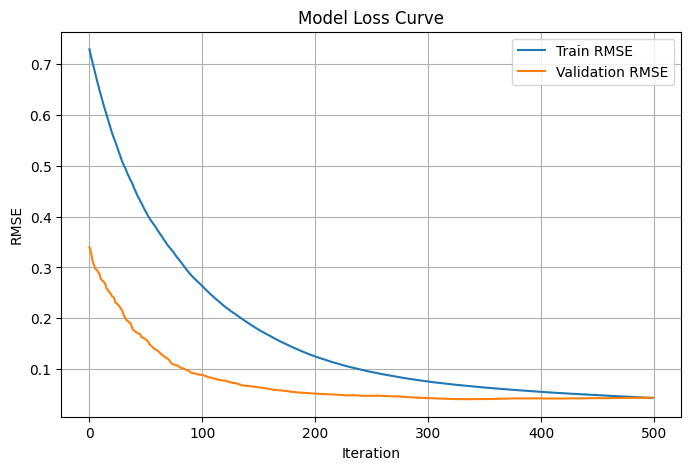

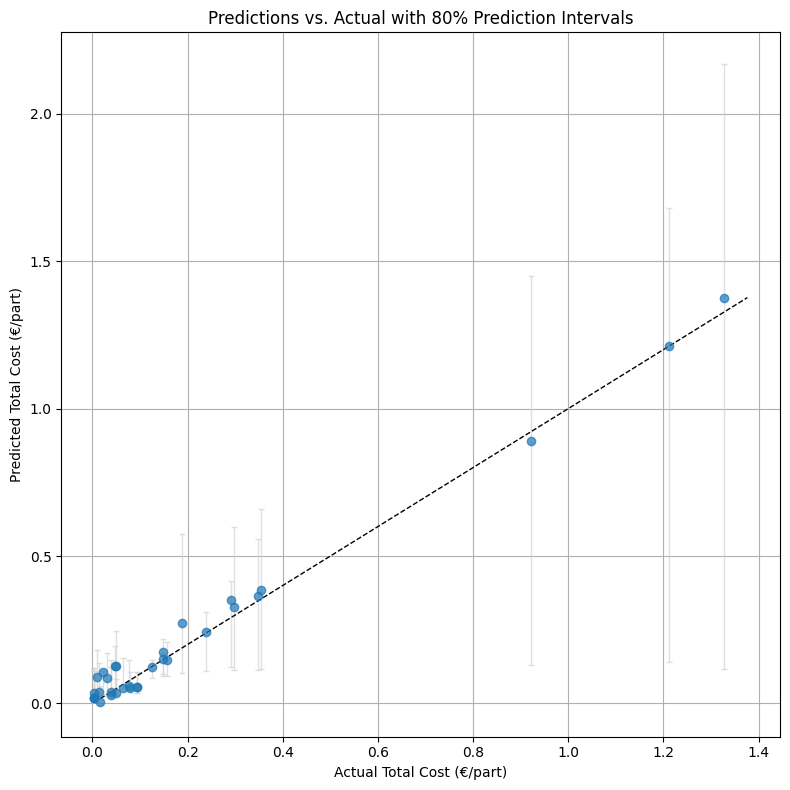

In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import optuna

# --- Feature Lists ---
features_to_scale = [
    'Annual target quantity', 
    'Raw Material Cost (€/kg)', 
    'Thickness (mm)',
    'Part Net Weight (g)', 
    'Final Raw Material cost (€/Part)', 
    'Surface Treatment cost (€/Part)'
]

categorical_features = [
    'Production',
    'Raw Material',
    'Raw Material Designation',
    'Surface Treatment'
]

# --- Prepare DataFrame ---
for col in categorical_features:
    df[col] = df[col].astype(str)

scaler = RobustScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

selected_features = features_to_scale + categorical_features
X = df[selected_features]
y = df['Total cost with amortization (€/part)']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Compute Sample Weights for Imbalance ---
y_bins = pd.qcut(y_train, q=10, duplicates='drop')
bin_counts = y_bins.value_counts()
sample_weights = y_bins.map(lambda b: 1.0 / bin_counts[b])
sample_weights *= len(y_train) / sample_weights.sum()

# --- Bayesian Hyperparameter Search with Optuna ---
def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 2, 8),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 100),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'iterations': 500,
        'od_type': 'IncToDec',
        'early_stopping_rounds': 20,
        'grow_policy': 'Depthwise',
        'verbose': 0
    }
    model = CatBoostRegressor(**params)
    model.fit(
        X_train, y_train,
        cat_features=categorical_features,
        sample_weight=sample_weights,
        eval_set=(X_test, y_test)
    )
    preds = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, preds))

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50)

best_params = study.best_params
print(f"Best Params: {best_params}")
print(f"Best RMSE: {study.best_value:.4f}")

# --- Train Final Model with Best Params ---
best_params.update({'iterations': 500, 'od_type': 'IncToDec', 'early_stopping_rounds': 20, 'grow_policy': 'Depthwise', 'verbose': 100})
model = CatBoostRegressor(**best_params)
model.fit(
    X_train, y_train,
    cat_features=categorical_features,
    sample_weight=sample_weights,
    eval_set=(X_test, y_test),
    use_best_model=True
)

# --- Fit Quantile Models for Prediction Intervals ---
quantile_params = best_params.copy()
quantile_params.update({'depth': 2, 'iterations': 300, 'learning_rate': 0.02, 'l2_leaf_reg': 30, 'subsample': 0.4, 'min_data_in_leaf': 15, 'verbose': 0})
lower_model = CatBoostRegressor(**quantile_params, loss_function='Quantile:alpha=0.1')
upper_model = CatBoostRegressor(**quantile_params, loss_function='Quantile:alpha=0.9')

lower_model.fit(X_train, y_train, cat_features=categorical_features, sample_weight=sample_weights)
upper_model.fit(X_train, y_train, cat_features=categorical_features, sample_weight=sample_weights)

# --- Predictions on Test Set ---
y_pred = model.predict(X_test)
y_lower = lower_model.predict(X_test)
y_upper = upper_model.predict(X_test)

# --- Evaluation Metrics ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("=== Test Set Metrics ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# --- Plot: Loss Curve ---
evals = model.get_evals_result()
train_rmse = evals['learn']['RMSE']
val_rmse = evals['validation']['RMSE']
iterations = range(len(train_rmse))

plt.figure(figsize=(8, 5))
plt.plot(iterations, train_rmse, label='Train RMSE')
plt.plot(iterations, val_rmse, label='Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Model Loss Curve')
plt.legend()
plt.grid()
plt.show()

# --- Plot: Predictions vs. Actual with Quantile Error Bars ---
# Ensure non-negative error bars
#lower_error = np.abs(y_pred - y_lower)
#upper_error = np.abs(y_upper - y_pred)

plt.figure(figsize=(8, 8))
plt.errorbar(
    y_test,
    y_pred,
    yerr=[lower_error, upper_error],
    fmt='o',
    ecolor='lightgray',
    elinewidth=1,
    capsize=2,
    alpha=0.7
)
# Reference line x=y
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', lw=1)
plt.xlabel('Actual Total Cost (€/part)')
plt.ylabel('Predicted Total Cost (€/part)')
plt.title('Predictions vs. Actual with 80% Prediction Intervals')
plt.grid()
plt.tight_layout()
plt.show()
